# Blueberry ionomics, part 2 - visual demo of the Markov chain algorithm

In `01_stats.ipynb`, I used an algorithm which scans for the best path to move from the current condition to an optimal one. Here I show how it works.

In short, the algorithm starts with a model, the conditions of the observation and some convergence parameters.

1. Predict the output from the initial condition.
2. Generate `n` random points within a hypersphere with a given radius.
3. From these random samples, filter out those which fall outside the scope of the model to avoid extrapolation (with the Mahalanobis distance from the center and covariance of data).
4. Predict the output (yield) from the remaining samples.
5. Retain only the best output.
6. If the output is improved, keep it for the next round and shorten the radius by a factor.
7. If the output is not improved, leave it and keep the current state for the next round, then increase the radius by a factor.


In [1]:
library("tidyverse")
library("ggpubr")
library("caret")
library("akima")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift




While, in `01_stats.ipynb`, the algorithm sequentially improved yield by perturbing a multidimensional ionome, here we have only two dimensions (X and Y) and the algorithm is targetting higher topography (Z). For the demo, I use a random sample of 500 points taken from the `volcano` data set.

In [2]:
data("volcano")

In [3]:
volcano_tidy <- volcano %>%
  as_tibble() %>%
  rowid_to_column(var="X") %>%
  gather(key="Y", value="Z", -1) %>%
  mutate(Y=as.numeric(gsub("V","",Y))) # thanks https://www.r-graph-gallery.com/79-levelplot-with-ggplot2.html
mahadist <- mahalanobis(volcano_tidy %>% select(X, Y),
            center = volcano_tidy %>% select(X, Y) %>% colMeans + c(-10, 0),
            cov = matrix(c(0.015, -0.01, -0.01, 0.025), ncol = 2))^0.5
volcano_tidy <- volcano_tidy %>% filter(mahadist < 200) %>% sample_n(500)

Warning message:
“The `x` argument of `as_tibble.matrix()` must have unique column names if `.name_repair` is omitted as of tibble 2.0.0.
Using compatibility `.name_repair`.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


In [4]:
volcano_map <- interp(volcano_tidy$X, volcano_tidy$Y, volcano_tidy$Z, nx = 100, ny = 100) %>%
  interp2xyz() %>%
  data.frame() %>%
  drop_na()

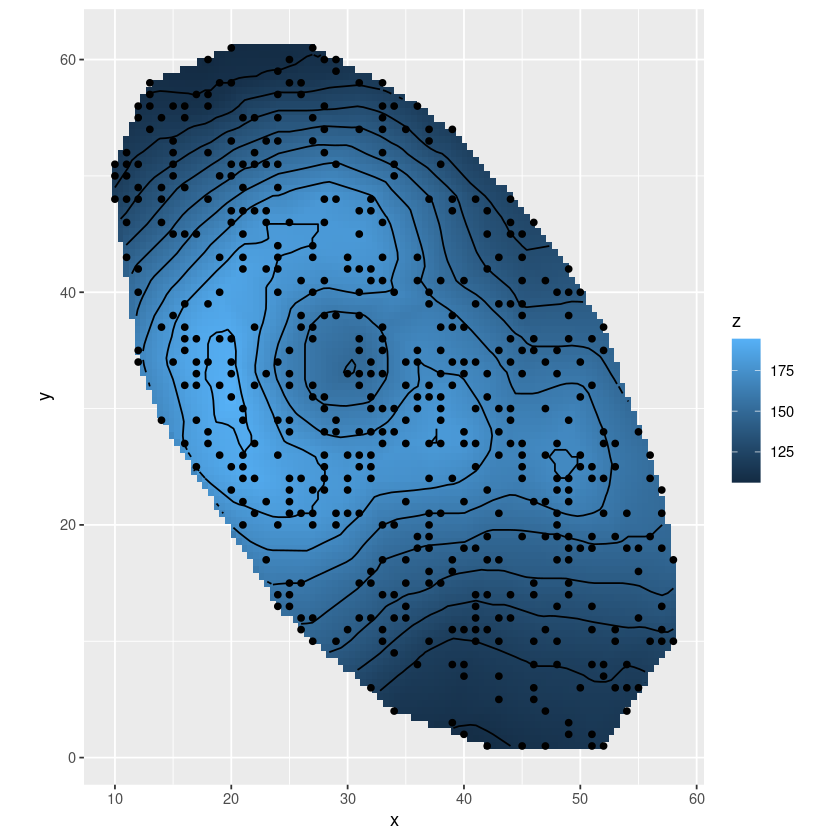

In [5]:
ggplot(volcano_map, aes(x = x, y = y)) +
  geom_tile(aes(fill = z)) +
  geom_contour(aes(z = z), colour = "black", binwidth = 10) +
  geom_point(data = volcano_tidy, aes(x = X, y = Y)) +
  coord_equal()

A machine learning model can be used to predict Z from X and Y. In machine learning, we usually use a training and testing set, and carefully train the model. But for the sake of this demo, a simple model suffice.

In [6]:
m_fit_ex <- train(Z ~ .,
               data = volcano_tidy,
               method = "gaussprRadial",
               verbose = FALSE
)

Machine learning doesn't raise a flag when it predicts outiside the scope of data. To avoid such extrapolation, the algorithm filters out random samples too far from the data cloud. The Mahalanobis distance is suited for our multivariate environment, and need the center of the scatter and its covariance. Have that, we set a critical distance not to overcome.

In [7]:
bal_mean_ex <- apply(volcano_tidy %>% select(-Z), 2, mean)
bal_icov_ex <- solve(cov(volcano_tidy %>% select(-Z)))
crit_dist_ex <- qchisq(p = 0.9, df = length(bal_mean_ex))

I create a grid of points where the model will predict the outcome, then filter out points of the grid too far from the scope of the model.

In [8]:
grid_ex <- expand.grid(X = seq(0, 70, length = 200),
                       Y = seq(-10, 70, length = 200))

In [9]:
maha_ex <- mahalanobis(grid_ex,
                       bal_mean_ex,
                       bal_icov_ex,
                       inverted = TRUE)

grid_ex <- grid_ex %>% 
  filter(maha_ex < crit_dist_ex)

Then I predict the output on the filtered grid.

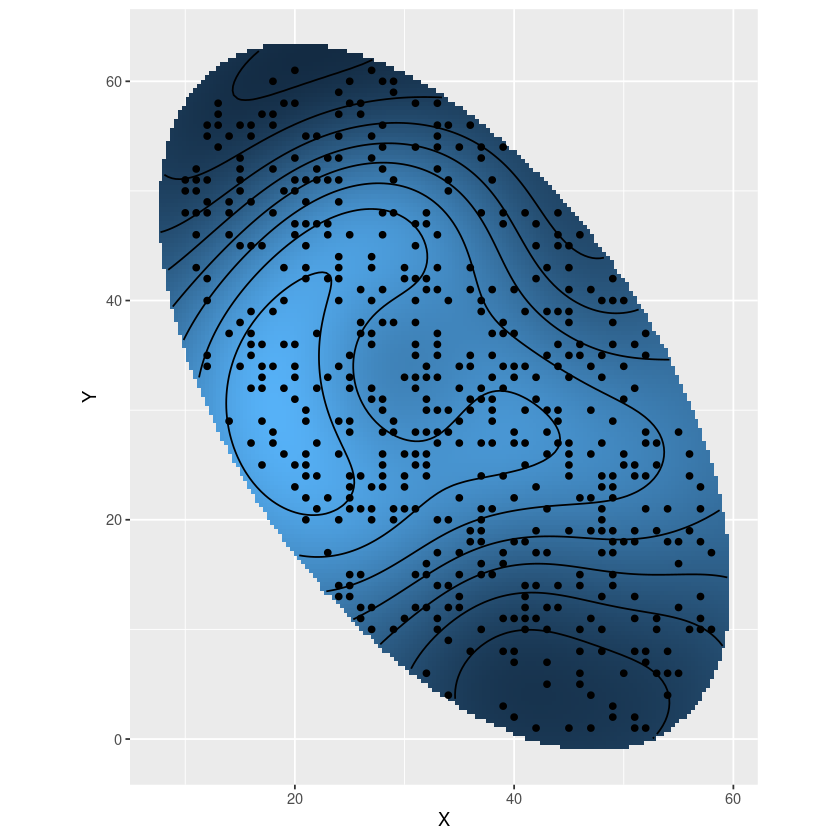

In [10]:
grid_ex$Z <- predict(m_fit_ex, newdata = grid_ex)

ggplot(grid_ex, aes(x = X, y = Y)) +
  geom_tile(aes(fill = Z), show.legend = FALSE) +
  geom_contour(aes(z = Z), colour = "black", binwidth = 10) +
  geom_point(data = volcano_tidy) +
  coord_equal()

This is how smooth Gaussian processes are. Now, before we launch the algorithm, we specify the number of iterations, the initial radius, its increasing / decreasing factor, its limits, the number of samples.

In [11]:
max_iter <- 50
radius <- rep(NA, max_iter)
radius[1] <- 3
radius_factor <- 1.2
radius_limits <- c(1, 12)
n_rad <- 500

The `ref_leaf` matrix retains the best ionome (here the X and Y coordinates returning the highest Z) at each step. The `ref_yield` is a vector storing the output (here, the predicted Z). I initialize the matrix with an observation, a point to start with, and I initialize the vector with its predicted outcome.

In [12]:
ref_leaf <- matrix(ncol = 2, nrow = max_iter)
ref_yield <- rep(NA, max_iter)

ref_leaf[1, ] <- c(42, 8)
ref_yield[1] <- predict(
  m_fit_ex,
  newdata = data.frame(X = ref_leaf[1, 1],
                       Y = ref_leaf[1, 2])
)

And I launch the algorithm.

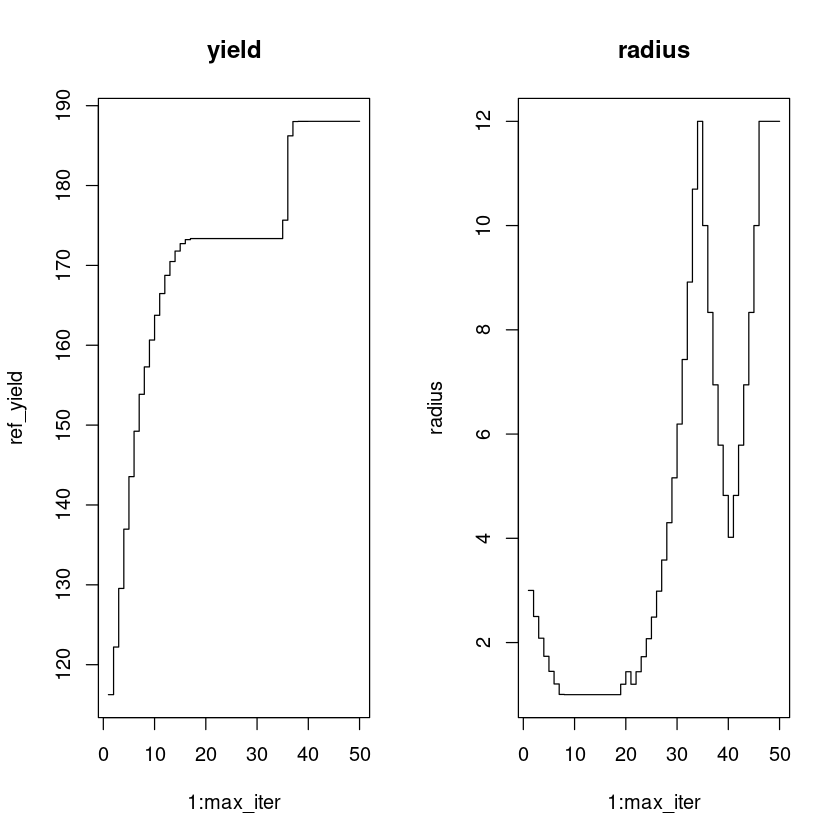

In [13]:
for (i in 2:max_iter) {
  
  # create a matrix of random numbers between -1 and 1
  offset <- matrix(runif(ncol(ref_leaf) * n_rad, -1, 1), 
                   ncol = ncol(ref_leaf),
                   nrow = n_rad)
  
  # normalize each row so that they have a lenght of the radius computed at the previous step
  offset <- t(apply(offset, 1, function(x) radius[i-1] * x / sqrt(sum(x^2))))
  
  # alter the offset to allow points inside the hypersphere, not just on the edge
  offset <- offset * runif(length(offset), 0, 1)
  
  # translate the ionome from its previous position to all of the random offsets
  leaf_search <- t(apply(offset, 1, function(x) x + ref_leaf[i-1, ] ))
                         
  # compute the Mahalanobis distance of all offseted points from the center/covariance of the
  # ionome data set to avoid extrapolation
  maha_dist <- mahalanobis(leaf_search, bal_mean_ex, bal_icov_ex, inverted = TRUE)
                         
  # filter out points to far from the center
  leaf_search <- data.frame(leaf_search) %>% filter(maha_dist < crit_dist_ex)

  # name the columns
  names(leaf_search) <- c("X", "Y")

  if(nrow(leaf_search) == 0) {
    
    # if no points are generated in the hyper ellipsoid, keep the reference but increase radius
    print(paste("Iteration", i, "- all points are out of the hyperellipsoid."))
    ref_yield[i] <- ref_yield[i-1]
    ref_leaf[i, ] <- ref_leaf[i-1, ]
    
    # increase the radius
    radius[i] <- radius[i - 1] * radius_factor
    radius[i] <- ifelse(radius[i] < radius_limits[1], radius_limits[1], radius[i])
    radius[i] <- ifelse(radius[i] > radius_limits[2], radius_limits[2], radius[i])
  } else {
    
    # if leaf_search is not empty, predict the output (Z)
    yield_stochastic <- predict(
      m_fit_ex,
      newdata = leaf_search
    )
    
    if(max(yield_stochastic) > ref_yield[i-1]) {
      
      # if we can find an ouput (Z) higher than the previous one, take its value
      # and its position as the new reference
      ref_yield[i] <- max(yield_stochastic)
      ref_leaf[i, ] <- leaf_search[which.max(yield_stochastic), ] %>% unlist()
      
      # ... and decrease the radius, making sure it don't cross the limits
      radius[i] <- radius[i - 1] / radius_factor
      radius[i] <- ifelse(radius[i] < radius_limits[1], radius_limits[1], radius[i])
    } else {
        
      # if we can't find an ouput (Z) higher than the previous one, 
      # keep the previous values
      ref_yield[i] <- ref_yield[i-1]
      ref_leaf[i, ] <- ref_leaf[i-1, ]
      
      # ... and increase the radius
      radius[i] <- radius[i - 1] * radius_factor
      radius[i] <- ifelse(radius[i] > radius_limits[2], radius_limits[2], radius[i])
    }
  }
}

par(mfrow = c(1, 2))
plot(1:max_iter, ref_yield, type = 's', main = "yield")
plot(1:max_iter, radius, type = 's', main = "radius")

The plot would be more elegant as an animation.

In [14]:
n_points_circle <- 50
theta <- seq(0, 2 * pi, length = n_points_circle)
ref_leaf <- data.frame(ref_leaf)
names(ref_leaf) <- c("X", "Y")

In [15]:
ait_circle <- list()
ait_circle[[1]] <- ref_leaf[1, ]
ait_circle[[1]]$iteration <- 1
for (i in 2:max_iter) {
  ait_circle[[i]] <- data.frame(X = radius[i-1] * cos(theta) + ref_leaf[i-1, 1],
                                Y = radius[i-1] * sin(theta) + ref_leaf[i-1, 2])
  ait_circle[[i]]$iteration <- i
}
ait_circle <- do.call(rbind.data.frame, ait_circle)


In [16]:
ref_leaf$iteration <- 1:nrow(ref_leaf)

In [17]:
ait_circle$rank <- "In between"
ait_circle$rank[ait_circle$iteration == 2] <- "first"
ait_circle$rank[ait_circle$iteration == max_iter] <- "last"

For comparison, find optimum with `optim` using defaults.

In [18]:
fr <- function(x, model) 1/predict(model, newdata = data.frame(X = x[1], Y = x[2]))

In [19]:
opt_leaf <- optim(par = c(42, 8), fr, model = m_fit_ex)

In [20]:
opt_coord <- data.frame(X = opt_leaf$par[1], Y = opt_leaf$par[2], Z = opt_leaf$value)

Plot the optimisation process.

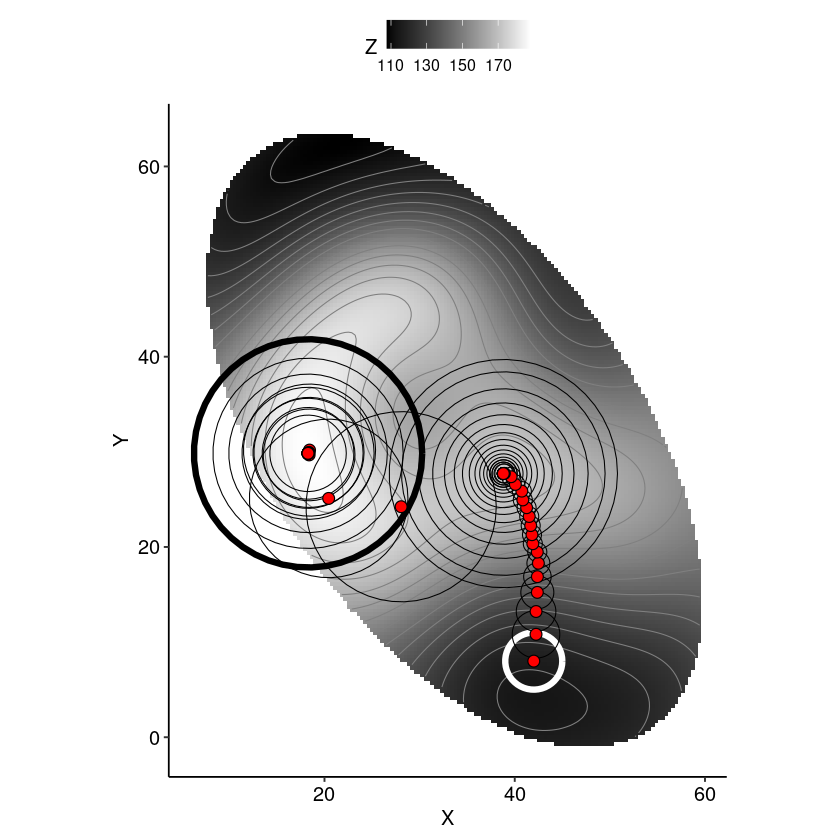

In [21]:
ggplot(grid_ex, aes(X, Y)) +
  geom_tile(aes(fill = Z)) +
  geom_contour(aes(z = Z), colour = "grey50", lwd = 0.3, binwidth = 5, linetype = 1) +
  geom_path(data = ait_circle, aes(group = iteration, colour = rank, size = rank), show.legend = FALSE) +
  geom_point(data = ref_leaf, fill = "red", pch = 21, size = 3) +
  #geom_point(data = opt_coord, fill = "white", pch = 23, size = 5) +
  coord_equal() +
  scale_fill_gradient(low = "black", high = "white") +
  scale_colour_manual(values = c("white", "black", "black")) +
  scale_size_manual(values = c(1.8, 0.3, 1.8)) +
  theme_pubr() +
  ggsave("images/convegence-algo_1.png", height = 6, width = 6, dpi = 600)

The path of the point can be animated. However, the radius couldn't since a path seems do be difficult to animate. I'm leaving the code here, but it is not executed.

To be able to display the radius, I exported a series of png, then created the gifs with image magick on Ubuntu with `convert -delay 20 *.png -loop 0 worm-anim.gif`.

In [22]:
theta <- seq(0, 2 * pi, length = 200)

for (i in 2:max_iter) {
  ggplot(grid_ex, aes(X, Y)) +
    geom_tile(aes(fill = Z)) +
    geom_contour(aes(z = Z), colour = "grey50", lwd = 0.3, binwidth = 5) +
    geom_path(data = ait_circle %>% filter(iteration == i)) +
    geom_point(data = ref_leaf[c(i-1), ], fill = "white", pch = 21, size = 2) +
    geom_point(data = ref_leaf[c(i), ], pch = "🐿", size = 4) +
    scale_fill_gradient(low = "black", high = "white") +
    coord_equal() +
    expand_limits(x = 5) +
    theme_pubr() +
    ggsave(paste0("images/anim/", sprintf("%02d", i), ".png"), height = 4, width = 4, dpi = 120)
}

In [23]:
system("convert -delay 20 images/anim/*.png -loop 0 images/anim/squirrel-scan.gif")

![](images/anim/worm-anim.gif)

Animated gifs are not accepted as graphical absract. Run squirrel, run!

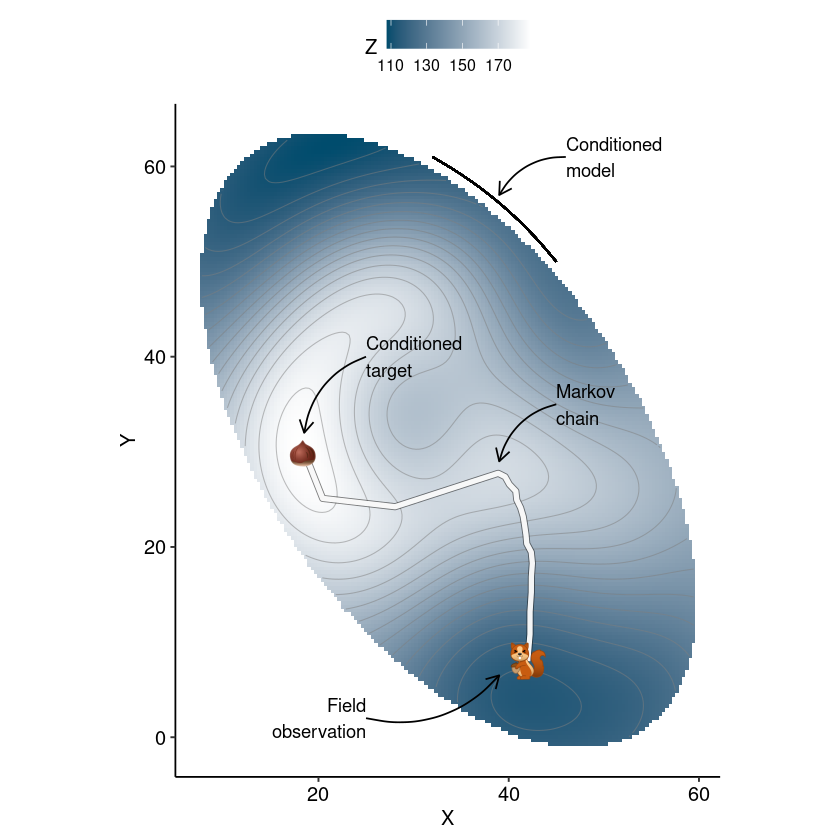

In [32]:
ggplot(grid_ex, aes(X, Y)) +
  geom_tile(aes(fill = Z)) +
  geom_contour(aes(z = Z), colour = "grey50", lwd = 0.3, binwidth = 5, linetype = 1, alpha = 0.5) +
  geom_path(data = ref_leaf, size = 2, alpha = 0.5) +
  geom_path(data = ref_leaf, size = 1.5, colour = "white", alpha = 0.95) +
  geom_point(data = ref_leaf[1, ], pch = "🐿", size = 7) +
  geom_point(data = ref_leaf[nrow(ref_leaf), ], pch = "🌰", size = 5) +
  # field observation
  annotate(
    geom = "curve", x = 25, y = 2, xend = 39, yend = 6.5, 
    curvature = .3, arrow = arrow(length = unit(3, "mm"))
  ) +
  annotate(geom = "text", x = 25, y = 2, label = "Field\nobservation", hjust = "right") +
  # target
  annotate(
    geom = "curve", x = 25, y = 40, xend = 18.5, yend = 32,
    curvature = .3, arrow = arrow(length = unit(3, "mm"))
  ) +
  annotate(geom = "text", x = 25, y = 40, label = "Conditioned\ntarget", hjust = "left") +
  # model
  geom_curve(x = 32, y = 61, xend = 45, yend = 50, curvature = -.1) +
  annotate(
    geom = "curve", x = 46, y = 61, xend = 39, yend = 57,
    curvature = .3, arrow = arrow(length = unit(3, "mm"))
  ) +
  annotate(geom = "text", x = 46, y = 61, label = "Conditioned\nmodel", hjust = "left") +
  # Markov chain
  annotate(
    geom = "curve", x = 45, y = 35, xend = 39, yend = 29,
    curvature = .3, arrow = arrow(length = unit(3, "mm"))
  ) +
  annotate(geom = "text", x = 45, y = 35, label = "Markov\nchain", hjust = "left") +
  coord_equal() +
  scale_fill_gradient(low = "#004c6d", high = "#ffffff") +
  scale_size_manual(values = c(1.8, 0.3, 1.8)) +
  theme_pubr() +
  ggsave("images/graphical-abstract.png", height = 6, width = 6, dpi = 600)

Here is how each component evolutes through iterations.

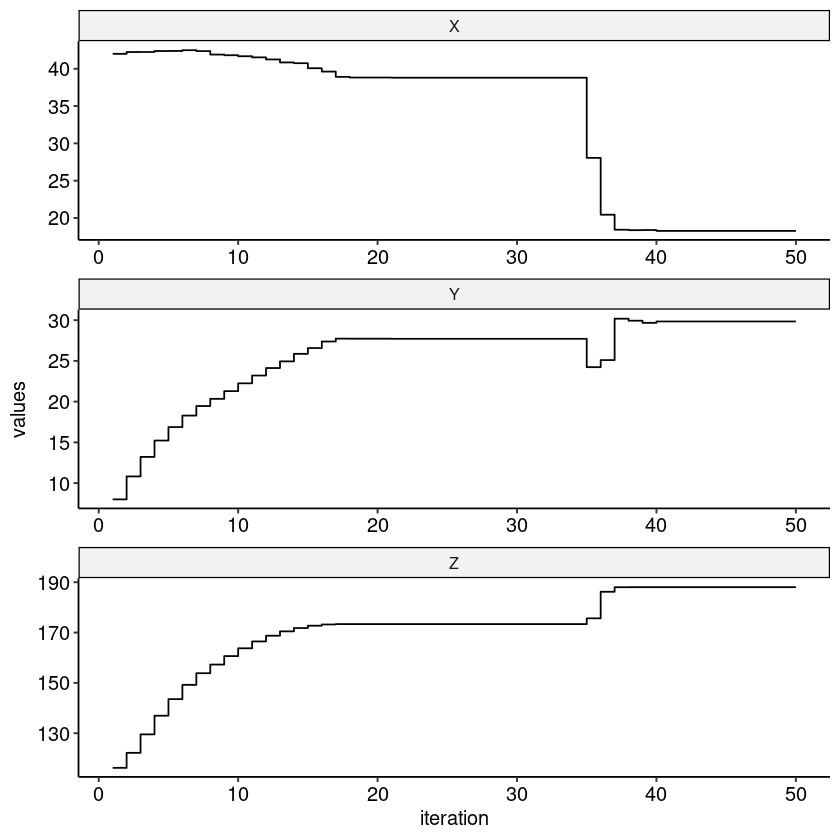

In [25]:
ref_leaf %>% 
  mutate(Z = ref_yield) %>%
  pivot_longer(cols = -iteration, names_to = "variable", values_to = "values") %>%
  ggplot(aes(iteration, values)) +
    facet_wrap(~variable, ncol = 1, scales = "free") +
    geom_step() +
    theme_pubr()